# Clustering and Unsupervised Analysis

Using k-means and hierarchical based clustering and incorporating SVD on survey data. 
The questions I am trying to answer:
<ul>
    <li>What is a good distance/similarity function?</li>
    <li>How many clusters is appropriate?</li>
    <li>How do we interpret/assess the clustering?</li>
</ul>


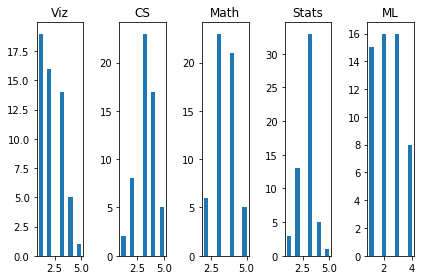

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
d = pd.read_csv('students_skills.csv',header=0,index_col=False)

dpro = d[['profile_{}'.format(k+1) for k in range(5)]]
dpro.columns = ['Viz','CS','Math','Stats','ML']

fig=plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.hist(dpro[dpro.columns.values[i]])
    plt.title(dpro.columns.values[i])

fig.tight_layout()
plt.show()

<p>I can see that most categories have a full range of values. An important question is how correlated are the values to each other. I will explore this question in two different ways.<br><br>

First let's look at the correlation of the different categories.
</p>

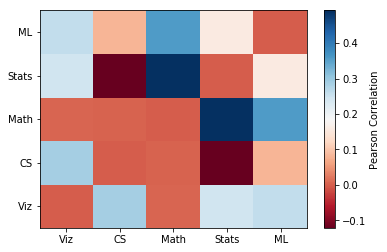

In [4]:
from matplotlib import pyplot as plt

#Get correlation and 0 out the diagonal (for plotting purposes)
c_mat = dpro.corr()
for i in range(c_mat.shape[0]):
    c_mat.iloc[i,i] = 0

fig, ax = plt.subplots()
heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)

#Set the tick labels and center them
ax.set_xticks(np.arange(c_mat.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(c_mat.shape[1])+0.5, minor=False)
ax.set_xticklabels(c_mat.index.values, minor=False)
ax.set_yticklabels(c_mat.index.values, minor=False)

cbar=plt.colorbar(heatmap)

cbar.set_label('Pearson Correlation')

plt.show()

<p>I can see a range of correlations, example - sets of strongly correlated features such as between "math/stats." It is perhaps not surprising that students that rank themselves on one aspect of each of these sets might rank themselves highly on the other. I can also see that these two groups of correlated features are uncorrelated with each other. From this we can certainly sense that distinct segments of the student population might be exist.
<br><br>

## Latent Variables

With this range of correlation in the data, I would like to check whether certain latent features might exist that can explain the above observations. <br><br>

One way to detect and define the latent features is through a decomposition of the observed features. The student survey results are stored in a matrix $X$. Ideally, latent features will all be independent, and each observed feature might be a linear combination of the latent features. One straightfoward mechanism to to mathematically arrive at the properties just described is via the singular value decomposition. 
For exploratory analysis of the survey data, I will use the SVD to define independent features (basically, latent features).<br><br>
This starts with the basic decomposition. We'll also generate a plot to get a sense of how important the various latent features are to the overall distribution of the data.


/Users/Rumi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


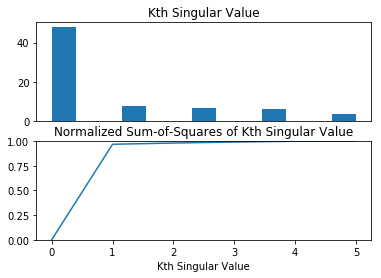

In [5]:
import sys
import course_utils as bd

U, sig, Vt = np.linalg.svd(dpro, full_matrices=0)
bd.plotSVD(sig)

plt.show()

<p>This is a fairly extreme outcome. Most of the data can be explained by the first singular vector and value. I can guess that this first (and very dominant) latent feature might be related to having self-reported math/stats skills. 

In [6]:
from sklearn import cluster

#Note - most of these input parms, except the first, help ensure stability of the fit
km = cluster.KMeans(n_clusters=2, init = 'k-means++', n_init = 5)
km.fit(dpro)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=5, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<p>Let's loop through different values of k to get the inertia as a function of k. I am also computing Silhoette Coefficient to evaluate clusters where true cluster labels are not known.

/Users/Rumi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


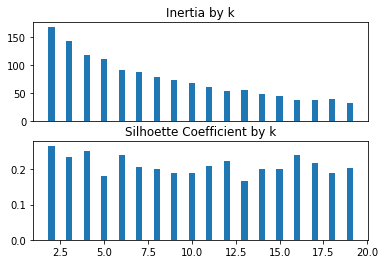

In [7]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics

inert_k = []
sil_k = []

for k in range(2,20):
    km = cluster.KMeans(n_clusters=k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    inert_k.append(km.inertia_)
    sil_k.append(metrics.silhouette_score(dpro, km.labels_, metric='euclidean'))    

fix = plt.figure()
ax1 = plt.subplot(211)
plt.bar(range(2,20), inert_k, 0.35)
plt.title('Inertia by k')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
ax1 = plt.subplot(212)
plt.bar(range(2,20), sil_k, 0.35)
plt.title('Silhoette Coefficient by k')

plt.show()

<p>I can see that increasing $k$ tends to continually decrease the inertia. But at the same time, the Silhouette Coefficient does not increase. I expect inertia to decrease as $k$ increases, but the other metric shows that this does not exactly result in good clusters.
<br><br>
</p

<p>Next I am trying to understand the distribution of clusters.
</p>

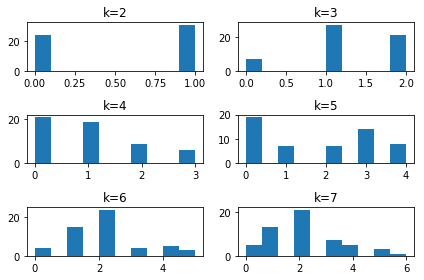

In [12]:
fig = plt.figure()
for k in range(2,8):
    km = cluster.KMeans(n_clusters=k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    ax = fig.add_subplot(3, 2 , k-1)
    plt.hist(km.labels_)
    plt.title('k={}'.format(k))

fig.tight_layout()

plt.show()

<p>Here I  can see that the clusters are actually pretty well balanced for all values of $k$ (x-axis shows cluster number, based on distance). Each choice of $k$ certainly has a clear maximum, but the differences aren't too extreme.<br><br>
Next, I would like to define the clusters based on the centroids. The centroid essentially describes the average student within each cluster. I can use that to better understand and then define the clusters. For comparison's sake, I will also show this for clusters derived using $U$ and $U\Sigma$. When doing this though, I have to remember to report the cluster means in the original $X$ space for us to be able to interpret it. To project the $U\Sigma$ centroids back into the $X$ space,I multiply the centroid by $V^T$ from the SVD.<br><br>
Another thing I do here is we subtract the mean of $X$ from each centroid. This is because I am more interested in how each cluster differs from the average student profile.
</p>

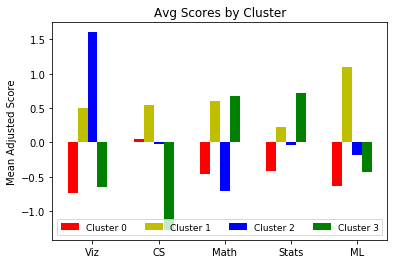

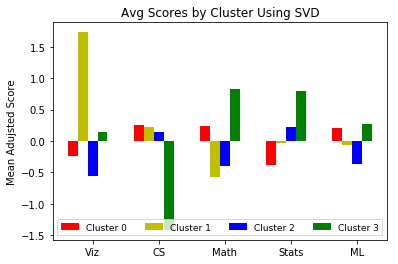

In [20]:
#Clustering on original X space
km = cluster.KMeans(n_clusters=4, init = 'k-means++', n_init = 10)
km.fit(dpro)
cols = ['r','y','b','g']

fig = plt.figure()
for i, cc in enumerate(km.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    plt.bar(np.arange(len(cc))+i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})
   
#Now cluster on the SVD space
km_u = cluster.KMeans(n_clusters=4, init = 'k-means++', n_init = 10)
#km_u.fit(pd.DataFrame(U.dot(diag(sig))))
km_u.fit(pd.DataFrame(U))
cols = ['r','y','b','g']

fig = plt.figure()
for i, cc in enumerate(km_u.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    #plt.bar(np.arange(len(cc))+i*w, cc.dot(Vt), w, color = cols[i], label='Cluster {}'.format(i))
    plt.bar(np.arange(len(cc))+i*w, cc.dot(np.diag(sig).dot(Vt)) - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adujsted Score')
plt.title('Avg Scores by Cluster Using SVD')
plt.legend(loc = 3, ncol = 4, prop={'size':9})

plt.show()


### Hierarchical Clustering


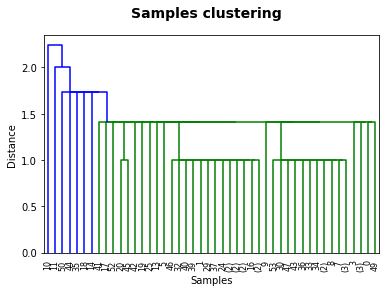

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

import pandas as pd

d = pd.read_csv('students_skills.csv',header=0,index_col=False)

dpro = d[['profile_{}'.format(k+1) for k in range(5)]]
dpro.columns = ['Viz','CS','Math','Stats','ML']


#This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(dpro)

#This function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists)

p = 46
#Now we want to plot the dendrogram
den = dendrogram(links, truncate_mode = 'lastp', p = p)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

plt.show()

In [33]:
links[:5,:]

array([[ 27.,  54.,   0.,   2.],
       [ 12.,  23.,   0.,   2.],
       [ 38.,  48.,   0.,   2.],
       [  6.,  51.,   0.,   2.],
       [ 21.,  26.,   0.,   2.]])

In [34]:
ka = cluster.AgglomerativeClustering(n_clusters = 4)
ka.fit(dpro)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=4,
            pooling_func=<function mean at 0x106160840>)

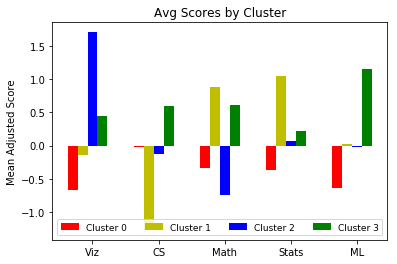

In [35]:
#Clustering on original X space using Hierarchical clustering

cols = ['r','y','b','g']

fig = plt.figure()
for i in range(4):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    cc = dpro[(ka.labels_==i)].mean()
    plt.bar(np.arange(len(cc))+i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})

plt.show()
   

When I plot the 4 clusters using hierarchical clustering, I get similar conceptual groupings as I did with k-means. However, I find this latter plot more easy to interpret.


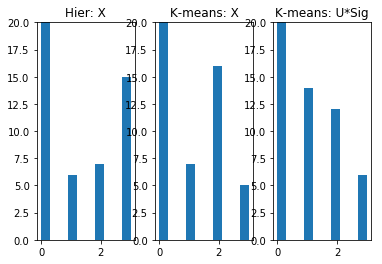

In [36]:

plt.subplot(1,3,1)
plt.hist(ka.labels_)
plt.ylim([0,20])
plt.title('Hier: X')

plt.subplot(1,3,2)
plt.hist(km.labels_)
plt.ylim([0,20])
plt.title('K-means: X')

plt.subplot(1,3,3)
plt.hist(km_u.labels_)
plt.ylim([0,20])
plt.title('K-means: U*Sig')

fig.tight_layout()


plt.show()